# Tae-Seung Kim Module 5


## Initial Section loaded from the linked kaggle notebook

In the kernel "The fallacy of encoding assetCode", @marketneutral makes the point that encoding assetCode and using either of the lightGBM built in feature importances (split and gain) results in assetCode being a significant feature. The advice was "Don't encode assetCode".

In this kernel, we experiment with using MDA feature importances as described in "Advances in Financial Machine Learning" by Marcos Lopez de Prado.

We use the code from @marketneutral's kernel to generate random data for the test.

Using this process, assetCode has no importance.

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.metrics import PrecisionRecallDisplay, f1_score, average_precision_score, roc_curve, precision_recall_fscore_support, precision_recall_curve, confusion_matrix, classification_report

In [159]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = 12, 7

In [160]:
class rfmodel:
    # on creation
    def __init__(self, name, data, seed=1):
        self.name = name
        self.xdata = data.copy().drop(['date','target'], axis=1)
        #dividends included is the target
        self.ydata = data['target'].copy()
        #any target giving > 0 returns is a good enough trade
        self.X_Train, self.X_Test, self.Y_Train, self.Y_Test = train_test_split(self.xdata, self.ydata, test_size=(1/3), random_state=1)
        self.seed = seed
        self.model = RandomForestClassifier(n_estimators=100,random_state=seed)
        

    def featImpMDA_classify(self,cv=10):
        X = self.xdata
        y = self.ydata
        np.random.seed(self.seed)
        # feat importance based on OOS score reduction
        print('start MDA',dt.datetime.now())
        from sklearn.metrics import log_loss
        cvGen=KFold(n_splits=cv)
        scr0,scr1=pd.Series(dtype='float64'),pd.DataFrame(columns=X.columns)
        for i,(train,test) in enumerate(cvGen.split(X=X)):
            print('   Split',i+1)
            X0, y0=X.iloc[train,:],y.iloc[train]
            X1, y1=X.iloc[test,:],y.iloc[test]  
            fit=self.model.fit(X=X0,y=y0.values.ravel())
            pred=fit.predict_proba(X1)
            #neg log loss from snippet 8.3
            scr0.loc[i]=-log_loss(y1,pred[:,1], sample_weight=None, labels=self.model.classes_)
            for j in X.columns:
                X1_=X1.copy(deep=True)
                np.random.shuffle(X1_[j].values) # permutation of a single column
                pred=fit.predict_proba(X1_)
            
                scr1.loc[i,j]=-log_loss(y1,pred[:,1], sample_weight=None, labels=self.model.classes_)
        #neg log loss from snippet 8.3
        imp=(-scr1).add(scr0,axis=0)
        imp=imp/-scr1
        imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
        print('end MDA',dt.datetime.now())
        self.imp_raw = imp
        self.imp = self.imp_raw.reset_index().rename(index=int,
                                                columns={"index":"Feature",'mean':'Importance'}, 
                                                inplace=False).set_index('Feature')
        self.imp = self.imp.sort_values(by='Importance')
        self.scr0 = scr0
        self.scr1 = scr1

    def fit(self):
        self.model.fit(self.X_Train, self.Y_Train)

    def pred(self):
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)
        self.train_probs = self.model.predict_proba(self.X_Train)
        self.test_probs = self.model.predict_proba(self.X_Test)
        self.train_probs = self.train_probs[:,1]
        self.test_probs = self.test_probs[:,1]
        

    def getAccuracy(self):
        self.precision_train, self.precision_train, self.train_threshold = metrics.precision_recall_curve(self.Y_Train, self.train_probs)
        self.precision_test, self.precision_test, self.test_threshold = metrics.precision_recall_curve(self.Y_Test, self.test_probs)
        self.auc_train = average_precision_score(self.Y_Train, self.Y_Pred_Train)
        self.auc_test = average_precision_score(self.Y_Test, self.Y_Pred_Test)
        self.train_acc = metrics.accuracy_score(self.Y_Train, self.Y_Pred_Train)
        self.test_acc = metrics.accuracy_score(self.Y_Test, self.Y_Pred_Test)
        self.f1_train = f1_score(self.Y_Train, self.Y_Pred_Train)
        self.f1_test = f1_score(self.Y_Test, self.Y_Pred_Test)
        self.bigscoretest = precision_recall_fscore_support(self.Y_Test, self.Y_Pred_Test, average='binary')
        self.bigscoretrain = precision_recall_fscore_support(self.Y_Train, self.Y_Pred_Train, average='binary')

    def makePRplot(self):
        
        self.plot1 = PrecisionRecallDisplay.from_predictions(self.Y_Test, self.Y_Pred_Test, drawstyle="default")
        self.plot1.ax_.set_title(self.name + " Test Precision Recall Curve")
        self.plot2 = PrecisionRecallDisplay.from_predictions(self.Y_Train, self.Y_Pred_Train, drawstyle="default")
        self.plot2.ax_.set_title(self.name + " Train Precision Recall Curve")
        #plt.show()
    
    def plot_importances(self, save=None, xrot=0, tickstep=3,
                     label_fontsize=12,
                     figsize=None, scalefig=(1.0, 1.0), show=True):
        """
        Given an array or data frame of importances, plot a horizontal bar chart
        showing the importance values.

        :param df_importances: A data frame with Feature, Importance columns
        :type df_importances: pd.DataFrame
        :param save: A filename identifying where to save the image.
        :param xrot: Degrees to rotate importance (X axis) labels
        :type xrot: int
        :param tickstep: How many ticks to skip in X axis
        :type tickstep: int
        :param label_fontsize:  The font size for the column names and x ticks
        :type label_fontsize:  int
        :param figsize: Specify width and height of image (width,height)
        :type figsize: 2-tuple of floats
        :param scalefig: Scale width and height of image (widthscale,heightscale)
        :type scalefig: 2-tuple of floats
        :param show: Execute plt.show() if true (default is True). Sometimes
                    we want to draw multiple things before calling plt.show()
        :type show: bool
        :return: None

        SAMPLE CODE

        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        X_train, y_train = ..., ...
        rf.fit(X_train, y_train)
        imp = importances(rf, X_test, y_test)
        plot_importances(imp)
        """
        df_importances = self.imp

        I = df_importances

        if figsize:
            fig = plt.figure(figsize=figsize)
        elif scalefig:
            fig = plt.figure()
            w, h = fig.get_size_inches()
            fig.set_size_inches(w * scalefig[0], h * scalefig[1], forward=True)
        else:
            fig = plt.figure()
        ax = plt.gca()
        labels = []
        for col in I.index:
            if isinstance(col, list):
                labels.append('\n'.join(col))
            else:
                labels.append(col)

        for tick in ax.get_xticklabels():
            tick.set_size(label_fontsize)
        for tick in ax.get_yticklabels():
            tick.set_size(label_fontsize)
        ax.barh(np.arange(len(I.index)), I.Importance, height=0.6, tick_label=labels)

        # rotate x-ticks
        if xrot is not None:
            plt.xticks(rotation=xrot)

        # xticks freq
        xticks = ax.get_xticks()
        nticks = len(xticks)
        new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
        ax.set_xticks(new_ticks)

        if save:
            plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
        if show:
            plt.show()



In [161]:
#load data
xdat = pd.read_csv('X_processed_final.csv')
ydat = pd.read_csv('y_final.csv')
combined = pd.concat([xdat, ydat], axis=1)
combined.rename(columns={'ret':'target', 'yyyymm':'date'}, inplace=True)

## Question1

Setting the random seed to 1, and using the same dataset as in the Module 4 assignment Download the same dataset as in the Module 4 assignment, compute the feature importance scores of each feature by applying the featImportance function (Snippet 8.8 in AFML) on the 10 cross validation sets within the train set defined there.

 Why can’t FS be applied to the train set as a whole? (For a hint, please read assetCode with MDA using random dataLinks to an external site..) (16 points)

Applying it to the entire train test could be a mostly mistake due to overfitting and train/test leaks. Our code is mostly focused on reducing overfitting while in Marcos Lopez de Prado's code, he accounts for removing the possibility of train test leakage by pruging & embargoing. 

Overfitting is bad because it boosts training scores while underperforming against new data. 


In [162]:
basemodel = rfmodel('basemodel', combined)

In [163]:
basemodel.featImpMDA_classify()

start MDA 2024-02-03 17:10:57.739500
   Split 1


   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2024-02-03 17:11:04.536501


In [164]:
basemodel.imp

,Importance,std
Feature,,
ntis,-0.008591,0.004666
svar,-0.005997,0.003306
b/m_FD,-0.001717,0.003911
corpr,-0.001279,0.003166
d/e,-0.000849,0.003109
dfr,0.000552,0.002402
lty_FD,0.000590,0.001541
tms,0.001301,0.003955
ltr,0.003176,0.004195


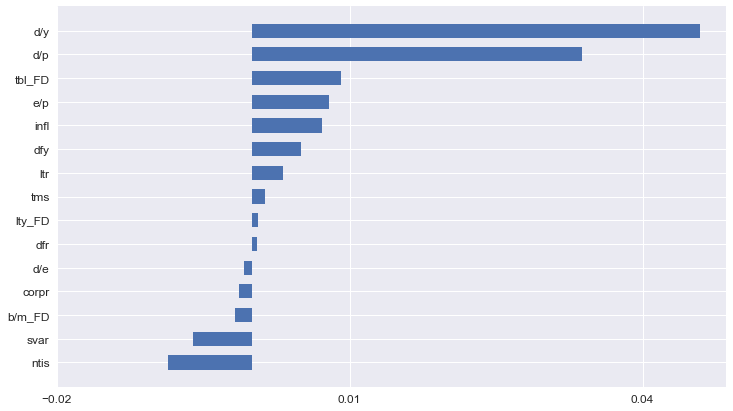

In [165]:
basemodel.plot_importances()

## Question 2

If you obtain a different FI score for a feature in each cross validation subset, how is the overall FI score computed? (8 points)

For each fold, every feature gets a log loss score. Then once all the folds are done the average is computed to give the score across all the folds.

In our example adapted from snippet 8.3 we focus on measuring the improvement of log loss via shuffling. 

scr0.loc[i]=-log_loss(y1,pred[:,1], sample_weight=None, labels=clf.classes_)

The above snippet establishes the baseline scr0. 

The following for loop in our code then calculates scr1. 

We the take the new score (-scr1).add(scr0, axis=0) and add it to the base score. 

so scr1 + scr0 / scr1 is the final measurement that tells us how important the feature is. 

In [166]:
basemodel.imp

,Importance,std
Feature,,
ntis,-0.008591,0.004666
svar,-0.005997,0.003306
b/m_FD,-0.001717,0.003911
corpr,-0.001279,0.003166
d/e,-0.000849,0.003109
dfr,0.000552,0.002402
lty_FD,0.000590,0.001541
tms,0.001301,0.003955
ltr,0.003176,0.004195


## Question 3

What are the 5 most important features? What are the features with above-average FI scores?

d/y, d/p, tbl_FD, e/p, infl are the top 5 and the ones with above-average FI scores

In [167]:
basemodel.imp.sort_values(by='Importance', ascending=False).head(5)

,Importance,std
Feature,,
d/y,0.045858,0.013417
d/p,0.033830,0.009905
tbl_FD,0.009122,0.002730
e/p,0.007938,0.005308
infl,0.007154,0.006951


In [168]:
all_avg = basemodel.imp['Importance'].mean()
print(f'mean of all FI scores: {all_avg:.4f}')
basemodel.imp[basemodel.imp['Importance'] > all_avg].sort_values(by='Importance', ascending=False)

mean of all FI scores: 0.0064


,Importance,std
Feature,,
d/y,0.045858,0.013417
d/p,0.033830,0.009905
tbl_FD,0.009122,0.002730
e/p,0.007938,0.005308
infl,0.007154,0.006951


## Question 4

If you use only those above-average features as input, and retrain a RF as in the Module 4 assignment to predict the same labels, do any of the performance metrics improve? (16 points)

First we fit the feature selected model the exact same way we did the original model. Then we got the scores.



| model                  |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |   f1_test |   auc_test |
|:-----------------------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|----------:|-----------:|
| basemodel               |          0.978593 |       0.963855 |   0.971168 |    0.96377  |         0.96988  |      0.964072 |  0.966967 |   0.955511 |
| feature_selected_model |          0.990683 |       0.960843 |   0.975535 |    0.974152 |         0.975309 |      0.946108 |  0.960486 |   0.953464 |

We can see that precision increases in both the train and test dataset.

However there is a slight decrease in recall, f1, and auc_pr scores.  F1 and auc_pr had a slight increase in train but did worse in the recall. 


In [169]:
feature_selected_model = rfmodel('feature_selected_model', 
                                 combined[['d/y', 'd/p', 'tbl_FD', 'e/p', 'infl','target','date']])

In [170]:
mod_list = [basemodel, feature_selected_model]

feature_selected_model.featImpMDA_classify()
feature_selected_model.pred()
feature_selected_model.getAccuracy()


basemodel.pred()
basemodel.getAccuracy()

bigholder = []
for x in mod_list:
    smallholder = {}
    smallholder['model'] = x.name
    smallholder['precision_train'] = x.bigscoretrain[0]
    smallholder['recall_train'] = x.bigscoretrain[1]
    smallholder['f1_train'] = x.bigscoretrain[2]
    smallholder['auc_train'] = x.auc_train
    smallholder['precision_test'] = x.bigscoretest[0]
    smallholder['recall_test'] = x.bigscoretest[1]
    smallholder['f1_test'] = x.bigscoretest[2]
    smallholder['auc_test'] = x.auc_test
    bigholder.append(smallholder)
    

start MDA 2024-02-03 17:11:04.785697
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2024-02-03 17:11:09.435828


In [171]:
scores_df = pd.DataFrame(bigholder)
scores_df

,model,precision_train,recall_train,f1_train,auc_train,precision_test,recall_test,f1_test,auc_test
0,basemodel,0.978593,0.963855,0.971168,0.963770,0.969880,0.964072,0.966967,0.955511
1,feature_selected_model,0.990683,0.960843,0.975535,0.974152,0.975309,0.946108,0.960486,0.953464


In [172]:
scores_df.to_markdown(index=False)

'| model                  |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |   f1_test |   auc_test |\n|:-----------------------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|----------:|-----------:|\n| basemodel              |          0.978593 |       0.963855 |   0.971168 |    0.96377  |         0.96988  |      0.964072 |  0.966967 |   0.955511 |\n| feature_selected_model |          0.990683 |       0.960843 |   0.975535 |    0.974152 |         0.975309 |      0.946108 |  0.960486 |   0.953464 |'

## Question 5

Now set the random seed to 2, and recompute #3. Are they different? (Hint: see Man, Xin and Chan, Ernest. 2021. “The Best Way to Select Features?". The Journal of Financial Data Science, Vol 3, Issue 1.) (8 points)

In Q3: d/y, d/p, tbl_FD, e/p, infl are the top 5 and the ones with above-average FI scores.

Now:

d/y, d/p, corpr, e/p/ infl are the top 5.

d/y, d/p, corpr, e/p are now the 4 with above average scores.

MDA is the least stable when considered with LIME and SHAP. So we could assume that LIME/SHAP should be stable across more random seeds (due to them converging closer to 0) which would mean that across random seeds, we would not see features drop in or out. With MDA, I assume we could monte carlo it and run a bunch of different seeds then see which features pop in or out.


In [173]:
rs2base = rfmodel('rs2base', combined, seed=2)
rs2base.featImpMDA_classify()

start MDA 2024-02-03 17:11:09.591072
   Split 1


   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2024-02-03 17:11:16.433666


In [174]:
rs2base.imp.sort_values(by='Importance', ascending=False).head(5)

,Importance,std
Feature,,
d/y,0.025970,0.008850
d/p,0.023451,0.005185
corpr,0.011250,0.006746
e/p,0.006753,0.004698
infl,0.003653,0.004613


In [175]:

rs2all_avg = rs2base.imp['Importance'].mean()
print(f'mean of all FI scores: {all_avg:.4f}')
rs2base.imp[rs2base.imp['Importance'] > all_avg].sort_values(by='Importance', ascending=False)

mean of all FI scores: 0.0064


,Importance,std
Feature,,
d/y,0.025970,0.008850
d/p,0.023451,0.005185
corpr,0.011250,0.006746
e/p,0.006753,0.004698


## Question 6

Retrain your RF model using the above-average features obtained in #5. Do any of the performance metrics improve over the Module 4 results? How do these metrics compare to those in #4 above? (16 points)

| model                     |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |   f1_test |   auc_test |
|:--------------------------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|----------:|-----------:|
| basemodel                  |          0.978593 |       0.963855 |   0.971168 |    0.96377  |         0.96988  |      0.964072 |  0.966967 |   0.955511 |
| feature_selected_model    |          0.990683 |       0.960843 |   0.975535 |    0.974152 |         0.975309 |      0.946108 |  0.960486 |   0.953464 |
| rs2base                   |          0.972477 |       0.957831 |   0.965099 |    0.955442 |         0.963415 |      0.946108 |  0.954683 |   0.942211 |
| rs2feature_selected_model |          0.979042 |       0.98494  |   0.981982 |    0.972859 |         0.975758 |      0.964072 |  0.96988  |   0.961178 |

So with feature selection from Q5 feeding the rs2feature_selected_model we can see that against original model there is again a slight improvement in precision.  Recall actually stays the same. F1 has a very slight increase and auc-pr is up half a point in test.

I think there's overall a slight increase in the metrics but with how unstable the MDA analysis is I don't think this can be conclusive. It would be interesting to see this test repliated with LIME & SHAP or 1000 iterations. The paper shows that the feature selection should result in a notable improvement when combined with high number of iterations for MDA or with LIME/SHAP.


In [176]:
rs2feature_selected = rfmodel('rs2feature_selected_model', 
                                 combined[['d/y', 'd/p', 'corpr', 'e/p', 'target', 'date']], seed=1)

rs2feature_selected.featImpMDA_classify()
rs2feature_selected.pred()
rs2feature_selected.getAccuracy()

rs2base.pred()
rs2base.getAccuracy()

rs2bigholder = []
mod2_list = [rs2base, rs2feature_selected]

for newmod in mod2_list:
    smallholder = {}
    smallholder['model'] = newmod.name
    smallholder['precision_train'] = newmod.bigscoretrain[0]
    smallholder['recall_train'] = newmod.bigscoretrain[1]
    smallholder['f1_train'] = newmod.bigscoretrain[2]
    smallholder['auc_train'] = newmod.auc_train
    smallholder['precision_test'] = newmod.bigscoretest[0]
    smallholder['recall_test'] = newmod.bigscoretest[1]
    smallholder['f1_test'] = newmod.bigscoretest[2]
    smallholder['auc_test'] = newmod.auc_test
    rs2bigholder.append(smallholder)


start MDA 2024-02-03 17:11:16.497124
   Split 1


   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2024-02-03 17:11:21.083132


In [177]:
rs2df = pd.DataFrame(rs2bigholder)
rs2df

,model,precision_train,recall_train,f1_train,auc_train,precision_test,recall_test,f1_test,auc_test
0,rs2base,0.972477,0.957831,0.965099,0.955442,0.963415,0.946108,0.954683,0.942211
1,rs2feature_selected_model,0.979042,0.984940,0.981982,0.972859,0.975758,0.964072,0.969880,0.961178


In [178]:
all_scores = pd.concat([scores_df, rs2df], axis=0)
all_scores

,model,precision_train,recall_train,f1_train,auc_train,precision_test,recall_test,f1_test,auc_test
0,basemodel,0.978593,0.963855,0.971168,0.963770,0.969880,0.964072,0.966967,0.955511
1,feature_selected_model,0.990683,0.960843,0.975535,0.974152,0.975309,0.946108,0.960486,0.953464
0,rs2base,0.972477,0.957831,0.965099,0.955442,0.963415,0.946108,0.954683,0.942211
1,rs2feature_selected_model,0.979042,0.984940,0.981982,0.972859,0.975758,0.964072,0.969880,0.961178


In [179]:
all_scores.to_markdown(index=False)

'| model                     |   precision_train |   recall_train |   f1_train |   auc_train |   precision_test |   recall_test |   f1_test |   auc_test |\n|:--------------------------|------------------:|---------------:|-----------:|------------:|-----------------:|--------------:|----------:|-----------:|\n| basemodel                 |          0.978593 |       0.963855 |   0.971168 |    0.96377  |         0.96988  |      0.964072 |  0.966967 |   0.955511 |\n| feature_selected_model    |          0.990683 |       0.960843 |   0.975535 |    0.974152 |         0.975309 |      0.946108 |  0.960486 |   0.953464 |\n| rs2base                   |          0.972477 |       0.957831 |   0.965099 |    0.955442 |         0.963415 |      0.946108 |  0.954683 |   0.942211 |\n| rs2feature_selected_model |          0.979042 |       0.98494  |   0.981982 |    0.972859 |         0.975758 |      0.964072 |  0.96988  |   0.961178 |'